# Product Category Classifier – Notebook

**Autor: Partenie Alexandru**

**Scop:** Acest notebook incearca sa demonstreze pas cum pas cum am antrenat un model
          de invatare automata care sa clasifice produsele introduse de la tastatura in
          categorii potrivite, pe baza titlulilor lor.

**Setul de date:**  
Fisierul `products.csv` contine peste 30.000 de produse si urmatoarele coloane:
- `Product ID`
- `Product Title`
- `Merchant ID`
- `Category Label`
- `Product Code`
- `Number of Views`
- `Merchant Rating`
- `Listing Date`

**Pasii urmati:**  
1. Curatarea si pregatirea datelor  
2. Ingineria caracteristicilor  
3. Antrenarea si compararea mai multor modele  
4. Evaluarea performantei  
5. Salvarea modelului final pentru utilizare ulterioara

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib


## 1. Incarcarea si explorarea datelor

Am incarcat setul de date `products.csv` si verific structura acestuia, valorile lipsa
si distributia categoriilor.


In [3]:
df = pd.read_csv("products.csv")

print("Dimensiunea datasetului:", df.shape)
df.head(5)


Dimensiunea datasetului: (35311, 8)


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


In [4]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB


product ID           0
Product Title      172
Merchant ID          0
 Category Label     44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
 Listing Date       59
dtype: int64

## 2. Curatarea datelor

Am eliminat valorile lipsa si am pastrat doar coloanele relevante:
- `Product Title` → textul produsului
- `Category Label` → eticheta (categoria)


In [5]:
df.columns = [c.strip() for c in df.columns]
df = df.dropna(subset=["Product Title", "Category Label"])

df = df[["Product Title", "Category Label"]]
df = df.rename(columns={"Product Title": "title", "Category Label": "category"})

df.head(3)


,title,category
0,apple iphone 8 plus 64gb silver,Mobile Phones
1,apple iphone 8 plus 64 gb spacegrau,Mobile Phones
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,Mobile Phones


## 3. Distributia categoriilor

Am analizat cate produse exista pentru fiecare categorie si am realizat un grafic pentru a observa posibile dezechilibre.


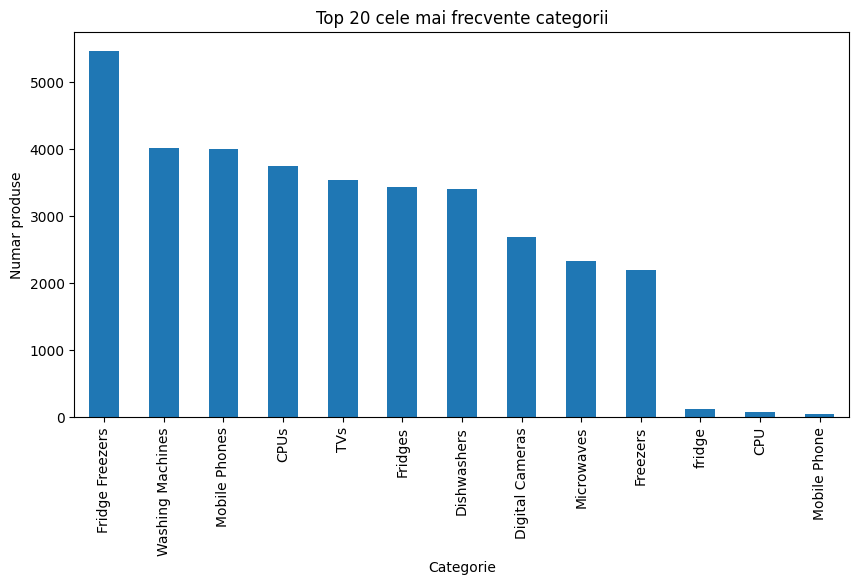

In [6]:
plt.figure(figsize=(10,5))
df["category"].value_counts().head(20).plot(kind="bar")
plt.title("Top 20 cele mai frecvente categorii")
plt.xlabel("Categorie")
plt.ylabel("Numar produse")
plt.show()


## 4. Ingineria caracteristicilor

Adaug cateva caracteristici suplimentare simple:
- Lungimea titlului
- Numarul de cifre
- Numarul de caractere speciale


In [7]:
df["title_length"] = df["title"].apply(len)
df["num_digits"] = df["title"].str.count(r"\d")
df["num_specials"] = df["title"].str.count(r"[^A-Za-z0-9 ]")
df.head(3)


,title,category,title_length,num_digits,num_specials
0,apple iphone 8 plus 64gb silver,Mobile Phones,31,3,0
1,apple iphone 8 plus 64 gb spacegrau,Mobile Phones,35,3,0
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,Mobile Phones,70,9,2


## 5. Impartirea datelor in seturi de antrenare si testare
Am separat 80% pentru antrenare si 20% pentru testare.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df["title"], df["category"], test_size=0.2, random_state=42, stratify=df["category"]
)
print("Date de antrenare:", len(X_train))
print("Date de testare:", len(X_test))


Date de antrenare: 28076
Date de testare: 7020


## 6. Antrenarea si compararea mai multor modele

Am decis sa compar doua modele:
- **Logistic Regression**
- **Linear SVC**


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

candidates = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Linear SVC": LinearSVC()
}

trained = {}
results = {}

for name, model in candidates.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), stop_words="english", max_features=5000, sublinear_tf=True)),
        ("clf", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    trained[name] = pipe
    print(f"{name} - acuratete: {acc:.6f}")


Logistic Regression - acuratete: 0.948860
Linear SVC - acuratete: 0.949858


## 7. Rezultatele evaluarii
In urma comparatiei acuratetii modelelor, am decis sa aleg LinearSVC deoarece a obtinut un scor mai bun decat Logistic Regression, chiar daca cu foarte putin


In [14]:
import pandas as pd

score_table = pd.DataFrame(
    [{"Model": k, "Acuratete": v} for k, v in results.items()]
).sort_values("Acuratete", ascending=False).reset_index(drop=True)

best_name = score_table.loc[0, "Model"]
best_pipe = trained[best_name]

print(f"Model castigator: {best_name} (acc = {results[best_name]:.6f})")
score_table


Model castigator: Linear SVC (acc = 0.949858)


,Model,Acuratete
0,Linear SVC,0.949858
1,Logistic Regression,0.948860


In [15]:
from sklearn.metrics import classification_report

y_pred = best_pipe.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))



                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        17
            CPUs       0.98      1.00      0.99       749
 Digital Cameras       0.99      0.99      0.99       538
     Dishwashers       0.93      0.96      0.94       681
        Freezers       0.97      0.92      0.94       440
 Fridge Freezers       0.93      0.94      0.93      1094
         Fridges       0.87      0.88      0.88       687
      Microwaves       0.99      0.96      0.97       466
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.97      0.99      0.98       801
             TVs       0.97      0.99      0.98       708
Washing Machines       0.95      0.94      0.95       803
          fridge       0.00      0.00      0.00        25

        accuracy                           0.95      7020
       macro avg       0.73      0.74      0.73      7020
    weighted avg       0.94      0.95      0.95      7020



# 9. Matricea de confuzie
Am realizat o matrice de confuzie pentru a putea reprezenta vizual performanta modelului 
de clasificare. Conform graficului, coloana principala este colorata cu albastru inchis,
iar restul patratelor foarte pal colorate => modelul a prezis corect majoritatea produselor.

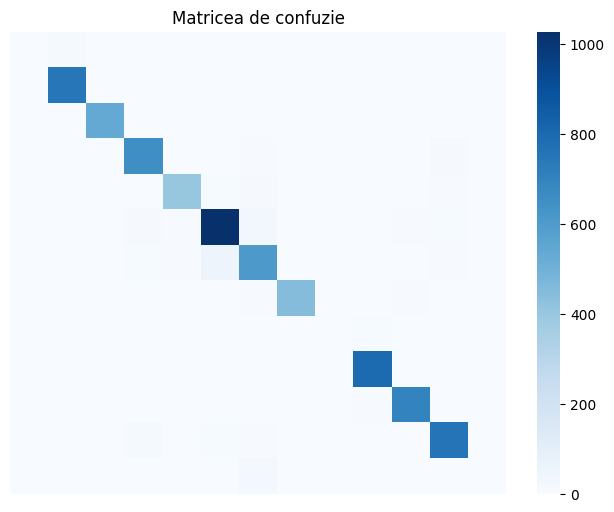

In [16]:
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Matricea de confuzie")
plt.show()


## 10. Salvarea modelului final
Modelul final a fost salveaza in format `.pkl` pentru utilizare ulterioara in scriptul `predict_category.py`.


## 11. Testare manuala

Testez modelul pe cateva titluri noi pentru a verifica predictiile.


In [17]:
exemple = [
    "iphone 7 32gb gold,4,3,Apple iPhone 7 32GB",
    "olympus e m10 mark iii geh use silber",
    "kenwood k20mss15 solo",
    "bosch wap28390gb 8kg 1400 spin",
    "bosch serie 4 kgv39vl31g",
    "smeg sbs8004po"
]

for text in exemple:
    pred = best_model.predict([text])[0]
    print(f"Titlu: {text}\nCategorie prezisa: {pred}\n{'-'*40}")


Titlu: iphone 7 32gb gold,4,3,Apple iPhone 7 32GB
Categorie prezisa: Mobile Phones
----------------------------------------
Titlu: olympus e m10 mark iii geh use silber
Categorie prezisa: Digital Cameras
----------------------------------------
Titlu: kenwood k20mss15 solo
Categorie prezisa: Microwaves
----------------------------------------
Titlu: bosch wap28390gb 8kg 1400 spin
Categorie prezisa: Washing Machines
----------------------------------------
Titlu: bosch serie 4 kgv39vl31g
Categorie prezisa: Dishwashers
----------------------------------------
Titlu: smeg sbs8004po
Categorie prezisa: Fridges
----------------------------------------


## 12. Concluzii finale

-> LinearSVC a obtinut cea mai buna acuratete.  
-> Modelul poate clasifica produse noi doar pe baza titlului.  
-> Modelul a fost salvat si poate fi folosit interactiv cu `predict_category.py`.

**Urmatori pasi:**
- Adaugarea de caracteristici suplimentare (brand, lungime cuvinte etc.)
- Optimizarea parametrilor TF-IDF
- Testarea cu modele avansate (BERT, fastText)
